In [11]:
import numpy as np
from math import sin, atan, tan, cos, log
import matplotlib.pyplot as plt

9

## Helper methods

In [2]:
# First, a wrapper method that takes a function for finding yn+1 
# given yn and other pertinent data and gets the t and y vectors
def get_method_results( method_f, yprime, a, b, y0, n ):
    h = (b-a)/n
    # Use the generator method below 
    method = method_gen( method_f, yprime, a, y0, h )
    # And pull the ts and ys from it
    t0, y0 = next(method)
    ts = [t0]
    ys = [y0]
    while len(ts) <= n:
        tn, yn = next(method)
        ts.append(tn)
        ys.append(yn)
    return ts, ys

# This is a method that takes a method for calculating a new y and returns a generator
def method_gen( method, y_prime, t0, y0, h ):
    current_y = y0
    current_t = t0
    while True:
        yield (current_t, current_y)
        current_y = method(y_prime, current_y, current_t, h)
        current_t = current_t + h

## Problem 1

In [13]:
# Then, defining a method is as simple as creating a method with the right signature
def forward_euler_method(y_prime, current_y, current_t, h):
    return current_y + h * y_prime( current_t, current_y )

# Wrap it with a convenience funtion, and we're done
def forward_euler(y_prime, a, b, y0, n = 100):
    return get_method_results( forward_euler_method, y_prime, a, b, y0, n )

## Problem 2

In [4]:
def RK4_method(y_prime, current_y, current_t, h):
    k1 = y_prime( current_t, current_y )
    k2 = y_prime( current_t + h/2, current_y + h*k1/2 )
    k3 = y_prime( current_t + h/2, current_y + h*k2/2 )
    k4 = y_prime( current_t + h, current_y + h*k3)
    return current_y + h / 6 * (k1 + 2*k2 + 2*k3 + k4)

# Wrap it with a convenience funtion, like above
def RK4(y_prime, a, b, y0, n = 100):
    return get_method_results( RK4_method, y_prime, a, b, y0, n )

## Problem 3

In [19]:
# For Backwards Euler, we need newtons method. Let's copy the code from project 2 here. 
def newtons_guesses( f, f_prime, x0 ):
    current_x = x0;
    while True:
        yield current_x
        next_x = current_x - (f(current_x) / f_prime(current_x))
        current_x = next_x

def newtons_method( f, f_prime, x0, tol=1.0e-5, ittr_max=100 ):
    guesses = newtons_guesses( f, f_prime, x0 )
    ittr_count = 1
    current_guess = next(guesses) # it yields x0 first
    next_guess = next(guesses)
    while (np.abs(next_guess - current_guess) > tol 
           and ittr_count < ittr_max):
        #print( current_guess )
        current_guess = next_guess
        next_guess = next(guesses)
        ittr_count += 1
    return next_guess

In [25]:
def squared( x ):
    return x ** 2

def squared_prime( x ):
    return 2 * x

print( newtons_method( squared, squared_prime, 5) )
print( newtons_method( lambda x : x**3, lambda x : 3 * x ** 2, 5) )

9.5367431640625e-06
1.738365016948853e-05


In [6]:
# This is a bit of a hack, but it alows us to use the above code by creating
# the BE method at creation time, and passing in the y_prime_dy function. We
# can then wrap it in a lambda to perserve the scope when this is evaluated.
# Now if only python supported multi-line lambdas, this wouldn't look like 
# such a mess *rages*
def build_BE_method( y_prime_dy ):
    return lambda y_prime, current_y, current_t, h : newtons_method( 
        get_f( current_y, h, y_prime, current_t + h), 
        get_f_prime( h, y_prime_dy, current_t + h ), 
        current_y,
        tol = 10e-7,
        ittr_max = 100
    )

# This generates the non-linear function to solve in the BE method
def get_f(current_y, h, y_prime, next_t):
    return lambda x: current_y - x + h * y_prime(next_t, x)

# This is the derivative of that non-linear function, needed for Newtons method
def get_f_prime(h, y_prime_dy, next_t):
    return lambda x: h * y_prime_dy(next_t, x) - 1

# Wrap it with a convenience funtion, and we're done
def backward_euler(y_prime, y_prime_dy, a, b, y0, n = 100):
    return get_method_results( build_BE_method(y_prime_dy), y_prime, a, b, y0, n )

## Problem 4

In [7]:
# First, we define a bunch of methods that we're going to need to plug in later:
def y_prime(t, y):
    return sin(y)/(1+t)

def y_true(t):
    cot_half = 1/tan(.5)
    return 2*atan((t + 1)/cot_half)

#This one is for backwards Euler only
def y_prime_dy(t, y):
    return cos(y)/(1+t)

#Short hand method for finding error
def max_error( ts, ys ):
    return max([ abs(y_true(t)-y) for t, y in zip(ts, ys)])

# as a little trick, we can define our methods as maps from names to functions 
# that are already prepopulated with most of the data. This makes evaluation
# of every function easier to loop later. 
def get_methods(a, b):
    return {
        "FE ": (lambda ittr_count: 
                forward_euler( y_prime, a, b, 1, ittr_count)),
        "RK4": (lambda ittr_count: 
                RK4( y_prime, a, b, 1, ittr_count)),
        "BE ": (lambda ittr_count: 
                backward_euler( y_prime, y_prime_dy, a, b, 1, ittr_count))
    }

### 4 a, b, and c

In [8]:
methods = get_methods(0,20)

for ittr_count in [500, 1000, 2000]:
    for m in methods:
        ts, ys = methods[m](ittr_count)
        print( "Error at {} ittrs for method {} is {}".
              format(ittr_count, m, max_error(ts, ys)))

Error at 500 ittrs for method FE  is 0.010659661546484678
Error at 500 ittrs for method RK4 is 5.279037207372994e-10
Error at 500 ittrs for method BE  is 0.010593098515223165
Error at 1000 ittrs for method FE  is 0.005321602711385598
Error at 1000 ittrs for method RK4 is 3.455902231053187e-11
Error at 1000 ittrs for method BE  is 0.005305015170636196
Error at 2000 ittrs for method FE  is 0.0026587485869593586
Error at 2000 ittrs for method RK4 is 2.2086776851892864e-12
Error at 2000 ittrs for method BE  is 0.0026545956748784683


### 4 d

In [9]:
methods = get_methods(0,20)

for m in methods:
    ts1, ys1 = methods[m](1000)
    e1000 = max_error( ts1, ys1 )
    ts2, ys2 = methods[m](2000)
    e2000 = max_error( ts2, ys2 )
    cvgnc = log(e1000/ e2000) / log( (20/1000) / (20/2000) )
    print( "Rate of convergence for method {} is {}".
            format( m, cvgnc))

Rate of convergence for method FE  is 1.001113447359553
Rate of convergence for method RK4 is 3.9678075985598333
Rate of convergence for method BE  is 0.9988647378950698


### 4 e

Yes. These rates of convergence confirm our theoretical analysis. For both FE and BE, the rate is very close to 1, as expected, while for RK4, it is almost exactly 4. 

## Problem 5

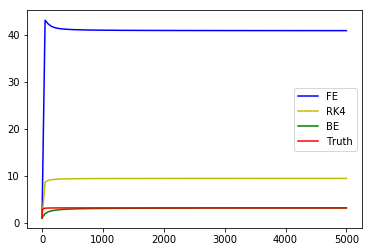

In [22]:
long_term_methods = get_methods(0, 5000)

colors = {
    "FE ": 'b-',
    "RK4": 'y-',
    "BE ": 'g-'
}


for m in methods:
    ts, ys = long_term_methods[m](100)
    plt.plot(ts, ys, colors[m], label = m)

ts = range(0, 5000)
ys = [y_true(t) for t in ts]
plt.plot(ts, ys, 'r-', label = "Truth")
plt.legend()

plt.show()

In this case, BE is the best approximation. This is because BE is an A-stable method, unlike RK4 or FE. For those methods, the relativly large h means that we no longer fall within the zone of stability for the function. 